In [3]:
import numpy as np
import pickle
import json
import os
import sys
import copy
import sklearn.preprocessing
import models
from sklearn.neighbors import NearestNeighbors
import utils
from collections import Counter
import matplotlib.pyplot as plt

In [4]:
data='fb15k'
DATA_DIR = "../../data/"+data
DUMP_FILE = "../dumps/"+data+"_distmult_dump_norm.pkl"
MODEL_TYPE = data
mining_dir=data+"_low_thresh"
os.system("mkdir -p "+mining_dir)

0

In [5]:
train_data = utils.read_data(os.path.join(DATA_DIR,"train.txt"))
# dev_data = read_data(os.path.join(DATA_DIR,"valid.txt"))
# test_data = read_data(os.path.join(DATA_DIR,"test.txt"))

In [6]:
dump=utils.load_pickle(DUMP_FILE)
dump.keys()

dict_keys(['tail_rel_type', 'entity_type', 'entity_to_id', 'head_rel_type', 'entity_real', 'rel_real', 'relation_to_id'])

In [7]:
model=models.TypedDM(DUMP_FILE)

In [8]:
mapped_train_data = utils.map_data(train_data,dump)
# mapped_dev_data = map_data(dev_data)
# mapped_test_data = map_data(test_data)

In [9]:
entity_to_rel=utils.get_ent_to_rel(mapped_train_data)

In [10]:
index_head=utils.get_head_index(mapped_train_data)

# Length 1 Rules

In [9]:
relation_count=len(dump['relation_to_id'])
nbrs = NearestNeighbors(n_neighbors=relation_count,metric=model.similarity_relembedding).fit(model.relation_matrix)
print(relation_count)
count_r,set_r=utils.get_relation_dict(mapped_train_data)
print(len(count_r),len(set_r))
support=1

1345
1345 1345


In [10]:
rules_dict_1={}
count=0
count2=0
for r1 in range(relation_count):
    if(r1%100==0):
        print(r1)
    if(count_r[r1]<support):
        continue
    combined_rel=model.relation_matrix[r1].reshape((1,-1))
    distances, indices = nbrs.kneighbors(combined_rel)
    indices=indices[0]
    bool_arr=[False for i in range(relation_count)]
    for ind in indices:
        if ind!=r1:
            bool_arr[ind]=True
    cur_dict={}
    for pair_e1e2 in set_r[r1]:
        if pair_e1e2 not in entity_to_rel:
            print("Strange")
            continue
        for r2 in entity_to_rel[pair_e1e2]:
            count+=1
            if bool_arr[r2]==False:
                continue
            if r2 not in cur_dict:
                count2+=1
                cur_dict[r2]=0
            cur_dict[r2]+=1
    rules_dict_1[r1]=cur_dict            

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300


In [11]:
print(len(rules_dict_1))
print(count,count2)

1345
733548 4296


# Length 2 Rules

In [11]:
%time count_r1_r2,set_r1_r2=utils.get_r1r2_count(mapped_train_data,index_head,get_set=True)

CPU times: user 1min 55s, sys: 5.31 s, total: 2min
Wall time: 2min 3s


In [13]:
nbrs = NearestNeighbors(n_neighbors=500,metric=model.similarity_relembedding).fit(model.relation_matrix)
support=1

In [14]:
count=0
rules_dict={}
for r1 in range(relation_count):
    if(r1%100==0):
        print(r1)
    for r2 in range(relation_count):
        if(r1==r2):
            continue
        pair=(r1,r2)
        if(pair not in count_r1_r2 or count_r1_r2[pair]<support):
            continue
        
        combined_rel=model.dot_relation(r1,r2).reshape((1,-1))
        distances, indices = nbrs.kneighbors(combined_rel)
        
        bool_arr=[False for i in range(relation_count)]
        for ind in indices[0]:
            if ind!=r1 and ind!=r2:
                bool_arr[ind]=True
        
        if bool_arr[r1]==True or bool_arr[r2]==True:
            print("Strange")
            print(indices[0],r1,r2)
        
        cur_dict={}
        entpair_lis=list(set_r1_r2[pair])
        for pair_e1e2 in entpair_lis:
            if pair_e1e2 not in entity_to_rel:
                continue
            for r in entity_to_rel[pair_e1e2]:
                if(bool_arr[r]==False):
                    continue
                if r not in cur_dict:
                    count+=1
                    cur_dict[r]=0
                cur_dict[r]+=1
        rules_dict[pair]=cur_dict
        

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300


In [15]:
print(len(rules_dict))
print(relation_count)
print(count)

56651
1345
9328


# Saving rules

In [16]:
path1='1_sup=1.pkl'
path1=os.path.join(mining_dir,path1)
utils.dump_pickle(rules_dict_1,path1)
print(len(rules_dict_1))

1345


In [17]:
path2='2_sup=1_nei=500.pkl'
path2=os.path.join(mining_dir,path2)
utils.dump_pickle(rules_dict,path2)
print(len(rules_dict))

56651


## Saving auxilary data for rule2

In [18]:
path='set_r1_r2.pkl'
path=os.path.join(mining_dir,path)
set_len_r1_r2={}
for r1r2 in set_r1_r2:
    set_len_r1_r2[r1r2]=len(set_r1_r2[r1r2])
utils.dump_pickle(set_len_r1_r2,path)

In [19]:
print(len(count_r1_r2))

56863


## Analyse 3 Rules

In [47]:
rules_3=[]
count=0
count_dict={}

for r1r2 in set_r1_r2:
    count+=1
    if(count%100==0):
        print(count)
    for e1e2 in set_r1_r2[r1r2]:
        e1=e1e2[0]
        e2=e1e2[1]
        # e1-r1-e-r2-e2
        count_conf_dict={}
        
        # e1-r1-e-r2-e2-r3-e3
        if e2 not in index_head:
            continue
        for r3e3 in index_head[e2]:
            e3=r3e3[1]
            triplet=(r1r2[0],r1r2[1],r3e3[0])
            if triplet not in count_dict:
                count_dict[triplet]=0
                count_conf_dict[triplet]={}
            count_dict[triplet]+=1
            

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

In [52]:
print(len(count_dict))

1646816


In [53]:
value_list=list(count_dict.values())
cnt=Counter(value_list)
cnt=sorted(cnt.items())
array=np.array(cnt)
print(array.shape)

(30878, 2)


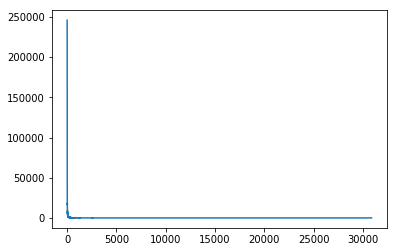

In [54]:
plt.plot(array[:,1])
plt.show()

In [55]:
temp=np.cumsum(array[:,1])/np.sum(array[:,1])
print(array[temp[:]<0.5],temp[temp[:]<0.5])

[[     1 245846]
 [     2 152144]
 [     3  90897]
 [     4  82622]
 [     5  51253]
 [     6  55643]
 [     7  34044]
 [     8  38312]
 [     9  28950]
 [    10  29029]] [0.14928565 0.24167242 0.29686802 0.34703877 0.37816125 0.41194948
 0.4326221  0.45588639 0.47346577 0.49109312]


## Rules Length 3

In [ ]:
min_sup=4
confidence=0
r1r2_ent=utils.get_r1r2_e1e2_dict(mapped_train_data,index_head)

In [ ]:
rules_3=[]
count=0

for r1r2 in set_r1_r2:
#     prit(r1r2)
    count+=1
    if(count%100==0):
        print(count)
        print(len(rules_3))
    for e1e2 in set_r1_r2[r1r2]:
        e1=e1e2[0]
        e2=e1e2[1]
        # e1-r1-e-r2-e2
        e=r1r2_ent[r1r2][e1e2]
        count_conf_dict={}
        count_dict={}
        
        # e1-r1-e-r2-e2-r3-e3
        if e2 not in index_head:
            continue
        for r3e3 in index_head[e2]:
            e3=r3e3[1]
            triplet=(r1r2[0],r1r2[1],r3e3[0])
            if triplet not in count_dict:
                count_dict[triplet]=0
                count_conf_dict[triplet]={}
            count_dict[triplet]+=1
            
            pair=(e1,e3)
            if pair not in entity_to_rel:
                continue
            for rel in entity_to_rel[pair]:
                if rel not in count_conf_dict[triplet]:
                    count_conf_dict[triplet][rel]=0
                count_conf_dict[triplet][rel]+=1
        
        for r1r2r3,supp in count_dict.items():
            if supp < min_sup:
                continue
            for r4,conf in count_conf_dict[r1r2r3].items():
                if conf>confidence:
                    rules_3.append((r1r2r3,r4,supp,conf))           
        

100
14232215
200
18987259
300
21947062
400
23150992


In [26]:
rules_3.sort(key=lambda x:(x[3]*1.0)/x[2],reverse=True)

In [27]:
path_rule_3=os.path.join(mining_dir,"3_sup=4_conf=0.pkl")

In [28]:
utils.dump_pickle(rules_3,path_rule_3)

## Load Len 3 rules

In [16]:
rules_3=utils.load_pickle(path_rule_3)

In [17]:
rules_3[0:10]

[((0, 30, 0), 0, 5, 9, 4467, 4467),
 ((0, 0, 0), 0, 5, 9, 4467, 4467),
 ((30, 0, 0), 0, 5, 9, 4467, 4467),
 ((30, 30, 0), 0, 5, 9, 4467, 4467),
 ((0, 0, 0), 0, 7, 9, 4467, 7639),
 ((0, 12, 0), 0, 4, 4, 268, 96842),
 ((0, 12, 8), 8, 4, 4, 268, 96842),
 ((0, 12, 8), 8, 4, 4, 10955, 96005),
 ((0, 12, 8), 8, 6, 6, 90199, 75683),
 ((0, 12, 8), 0, 4, 4, 16440, 73420)]

In [62]:
print(len(rules_3))

26395372


In [24]:
len(rules_3)

102926374

In [25]:
min_sup

4